In [34]:
from pathlib import Path
import sys
from itertools import product
import numpy as np
from typing import Tuple, List
from skimage.util import view_as_windows


class ImagePreparator:

    def __init__(self, 
                 img: np.ndarray, 
                 mask: np.ndarray, 
                 patch_size: int, 
                 overlap_ratio: float) -> None:
        
        self.img = img
        self.mask = mask
        self.source_shape = img.shape
        self.patch_size = patch_size
        self.overlap_ratio = overlap_ratio

        pass


    def add_padding(self, pad_size, mode='symmetric'):
        """Pad the image to in_size
            Args :
                img : numpy array of images
                in_size(int) : the input_size of model
                out_size(int) : the output_size of model
                mode(str) : mode of padding
            Return :
                padded_img: numpy array of padded image
        """

        self.img = np.pad(self.img, pad_size, mode=mode)
        self.mask = np.pad(self.mask, pad_size, mode=mode)
    

    def create_patches(self, padding : bool = False) -> Tuple[np.ndarray, np.ndarray]:
        """Split image and mask into patches using view_as_windows.

        Args:
            image: Input image array.
            mask: Input mask array.
            patch_size: Width and height of square patches.
            overlap: Fraction of pixels to overlap.
            min_threshold: Minimum fraction of pixels > 0 to keep patch.

        Returns:
            image_patches: Patched image array.
            mask_patches: Patched mask array.
        """
        

        self.img=self.fit_image(self.img)
        self.mask=self.fit_image(self.mask)
        
        step_size = (int(self.patch_size * (1 - self.overlap_ratio)), int(self.patch_size * (1 - self.overlap_ratio)))

        image_patches = view_as_windows(self.img, (self.patch_size, self.patch_size), step_size)
        mask_patches = view_as_windows(self.mask, (self.patch_size, self.patch_size), step_size)        
        
        # Flatten into patches
        self.n_patches_w = image_patches.shape[0]
        self.n_patches_h = image_patches.shape[1]
        image_patches = image_patches.reshape(image_patches.shape[0]*image_patches.shape[1], self.patch_size,self.patch_size)
        mask_patches = mask_patches.reshape(mask_patches.shape[0]*mask_patches.shape[1], self.patch_size,self.patch_size)

        return image_patches, mask_patches
            

    def stich_patches(self, image_patches: np.ndarray) -> np.ndarray:
        overlap_size = int(self.patch_size * self.overlap_ratio)
        reconstructed = np.zeros((self.n_patches_w * self.patch_size,
                              self.n_patches_h * self.patch_size))
        reconstructed_slices = [reconstructed for _ in range(len(image_patches))]

        idx_table = product(range(self.n_patches_w), range(self.n_patches_h))

        for n, (j, i) in enumerate(idx_table):
            patch = image_patches[n]
            h_idx = j * (self.patch_size - overlap_size)
            w_idx = i * (self.patch_size - overlap_size)
            reconstructed_slices[n][h_idx:h_idx+self.patch_size, w_idx:w_idx+self.patch_size] = patch

        reconstructed = np.max(reconstructed_slices, axis=0)
        
        if self.pad_h > 0 or self.pad_w > 0:
            reconstructed = reconstructed[:-self.pad_h, :-self.pad_w]
        reconstructed=reconstructed[0:self.source_shape[0],0:self.source_shape[1]]
        return reconstructed
    

    def filter_patches(self,
        patches: np.ndarray, 
        min_threshold: float
            ) -> List[int]:
        """Filter patches based on minimum mask threshold.
        
        Args:
            patches: Array of mask patches.
            min_threshold: Minimum fraction of pixels > 0 to keep patch.
            
        Returns: 
            keep_idx: List of indices of patches to keep.
        """
        
        keep_idx = []
        
        for i, patch in enumerate(patches):
            pixel_threshold_array = sorted(patch.flatten())
            threshold_idx = int(round(len(pixel_threshold_array) * (1 - min_threshold)))
            if pixel_threshold_array[threshold_idx] > 0:
                keep_idx.append(i)
            
        return keep_idx
    
    def fit_image(self, img):
        """Pad the image to ensure it is divisible by the patch size.

        Args:
            mode (str): Mode of padding.

        Returns:
            None
        """

        # Calculate the padding dims
        remainder_h = img.shape[0] % self.patch_size
        remainder_w = img.shape[1] % self.patch_size

        # Account for overlap
        overlap = int(self.patch_size * self.overlap_ratio)
        self.pad_h = (self.patch_size - remainder_h) % self.patch_size + overlap 
        self.pad_w = (self.patch_size - remainder_w) % self.patch_size + overlap

        # Pad the image
        img = np.pad(img, ((0, self.pad_h), (0, self.pad_w)), 
                    mode='constant', constant_values=0)
    
        return img


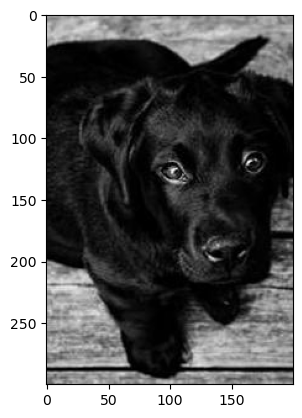

In [35]:
import cv2
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

req = urllib.request.urlopen('https://picsum.photos/id/237/200/300')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) # 'Load it as it is'
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_img, cmap='gray')

In [45]:
overlap_ratio = 0.05
size=50
prepare=ImagePreparator(gray_img, gray_img, size, overlap_ratio )
pimg, pmask = prepare.create_patches()

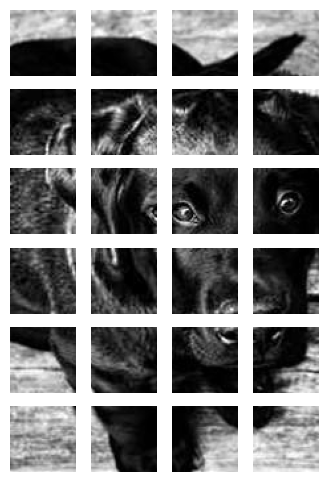

In [46]:

rows = prepare.n_patches_w
cols = prepare.n_patches_h

fig, axs = plt.subplots(rows, cols, figsize=(cols, rows))

for idx, img in enumerate(pimg):
    axs[idx // cols, idx % cols].imshow(img, cmap='gray')
    axs[idx // cols, idx % cols].axis('off')

plt.show()

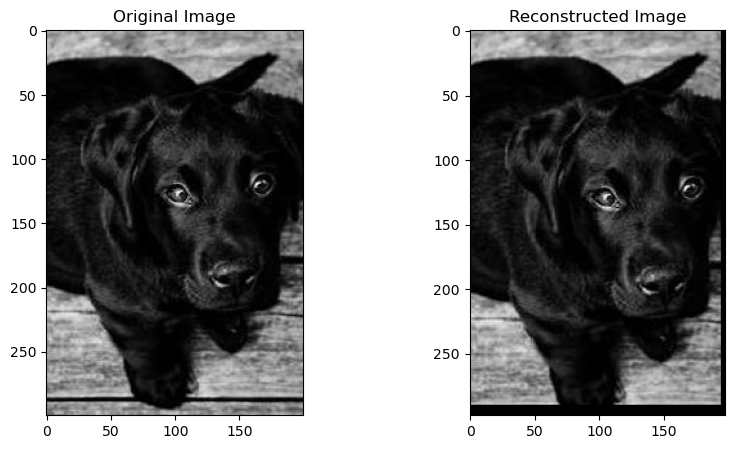

In [48]:

#prepare2=ImagePreparator2(gray_img, size, cols, rows, overlap_ratio)
reconstructed = prepare.stich_patches(pimg)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with two subplots side by side

# Plot the original image on the first subplot
axs[0].imshow(gray_img, cmap='gray')
axs[0].set_title('Original Image')

# Plot the reconstructed image on the second subplot
axs[1].imshow(reconstructed, cmap='gray')
axs[1].set_title('Reconstructed Image')

plt.show()

In [49]:
reconstructed.shape

(298, 198)

In [217]:
idx_table = product(range(24), range(4), range(6))


In [215]:
idx_table=product(range(24), idx_table)

In [349]:
from pathlib import Path
import sys
from itertools import product
import numpy as np
from typing import Tuple, List
from skimage.util import view_as_windows

class ImagePreparator2:

    def __init__(self, 
                 img: np.ndarray, 
                 patch_size: int, 
                 overlap_ratio: float) -> None:
        
        self.img = img
        self.source_shape = img.shape
        self.patch_size = patch_size
        self.overlap_ratio = overlap_ratio
        self.overlap_size = int(patch_size * overlap_ratio)

    def create_patches(self) -> Tuple[np.ndarray, np.ndarray]:
        """Split image and mask into patches using view_as_windows."""


        step_size = (self.patch_size - self.overlap_size, self.patch_size - self.overlap_size)
        img = self.fit_image(self.img, step_size)

        print(img.shape)
        image_patches = view_as_windows(img, (self.patch_size, self.patch_size), step_size)

        # Flatten into patches
        self.n_patches_w = image_patches.shape[1]
        self.n_patches_h = image_patches.shape[0]
        image_patches = image_patches.reshape(-1, self.patch_size, self.patch_size)

        return image_patches

    def stich_patches(self, image_patches: np.ndarray) -> np.ndarray:
        overlap_size = self.overlap_size
        
        reconstructed = np.zeros((self.n_patches_h * (self.patch_size - overlap_size) + self.overlap_size,
                                  self.n_patches_w * (self.patch_size - overlap_size) + self.overlap_size))
        reconstructed_slices = [np.zeros_like(reconstructed) for _ in range(len(image_patches))]


        idx_table = product(range(self.n_patches_h), range(self.n_patches_w))

        for n, (i, j) in enumerate(idx_table):
            patch = image_patches[n, :, :]
            h_idx = i * (self.patch_size - overlap_size)
            w_idx = j * (self.patch_size - overlap_size)
            reconstructed_slices[n][h_idx:h_idx+self.patch_size, w_idx:w_idx+self.patch_size] = patch

        reconstructed_slices=np.asarray(reconstructed_slices)
        reconstructed = np.max(reconstructed_slices, axis=0)

        # Crop the reconstructed image to the original size
        reconstructed = reconstructed[:self.source_shape[0], :self.source_shape[1]]

        return reconstructed

    def fit_image(self, img, step_size):
        """Pad the image to ensure it is divisible by the effective patch size."""

        # Calculate the padding dims
        remainder_h = img.shape[0] % step_size[0]
        remainder_w = img.shape[1] % step_size[1]

        pad_h = 2*step_size[0] - remainder_h if remainder_h else 0
        pad_w = 2*step_size[1] - remainder_w if remainder_w else 0

        # Pad the image
        print(pad_h, pad_w)
        img = np.pad(img, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)

        return img

In [350]:
overlap_ratio=.05
size=100
prepare=ImagePreparator2(gray_img,  size, overlap_ratio)
pimg = prepare.create_patches()
reconstructed = prepare.stich_patches(pimg)


175 180
(475, 380)


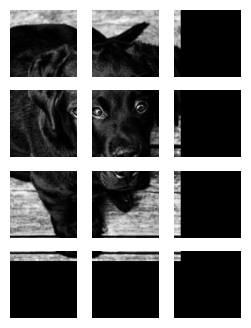

In [351]:
rows = prepare.n_patches_h
cols = prepare.n_patches_w

fig, axs = plt.subplots(rows, cols, figsize=(cols, rows))

for idx, img in enumerate(pimg):
    axs[idx // cols, idx % cols].imshow(img, cmap='gray')
    axs[idx // cols, idx % cols].axis('off')

plt.show()

Text(0.5, 1.0, 'Reconstructed Image')

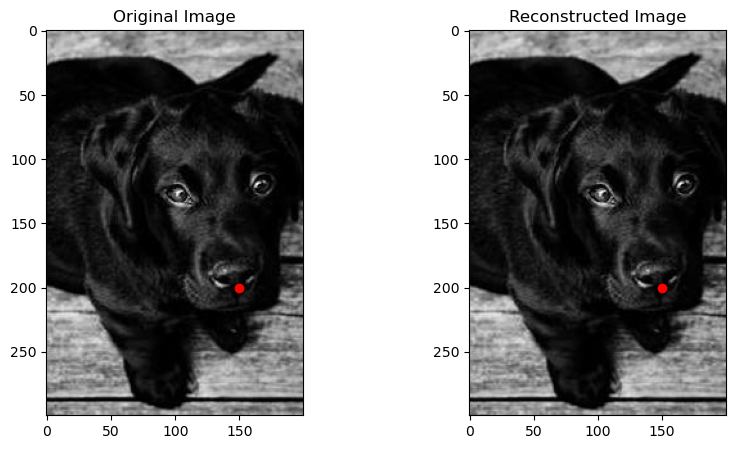

In [352]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with two subplots side by side

# Plot the original image on the first subplot
axs[0].imshow(gray_img, cmap='gray')
axs[0].scatter(150, 200, c='red') 
axs[0].set_title('Original Image')
# Plot the reconstructed image on the second subplot
axs[1].imshow(reconstructed, cmap='gray')
axs[1].scatter(150, 200, c='red') 

axs[1].set_title('Reconstructed Image')

In [399]:
from pathlib import Path
import sys
from itertools import product
import numpy as np
from typing import Tuple, List
from skimage.util import view_as_windows

class ImagePreparator:

    def __init__(self, 
                 img: np.ndarray, 
                 patch_size: int, 
                 overlap_ratio: float) -> None:
        """
        Initialize the ImagePreparator class.

        Args:
            img (np.ndarray): Input image array.
            patch_size (int): Width and height of square patches.
            overlap_ratio (float): Fraction of pixels to overlap.
        """
        self.img = img
        self.source_shape = img.shape
        self.patch_size = patch_size
        self.overlap_size = int(patch_size * overlap_ratio)

    def create_patches(self) -> np.ndarray:
        """
        Split the image into patches using view_as_windows.

        Returns:
            np.ndarray: Array of image patches.
        """

        step_size = (self.patch_size - self.overlap_size, self.patch_size - self.overlap_size)
        img = self.fit_image(self.img, step_size)
        image_patches = view_as_windows(img, (self.patch_size, self.patch_size), step_size)

        # Flatten into patches
        self.n_patches_w = image_patches.shape[1]
        self.n_patches_h = image_patches.shape[0]
        image_patches = image_patches.reshape(-1, self.patch_size, self.patch_size)

        return image_patches

    def stich_patches(self, image_patches: np.ndarray) -> np.ndarray:
        """
        Stitch the image patches back into a single image.

        Args:
            image_patches (np.ndarray): Array of image patches.

        Returns:
            np.ndarray: Reconstructed image array.
        """
        
        overlap_size = self.overlap_size
        
        reconstructed = np.zeros((self.n_patches_h * (self.patch_size - overlap_size) + self.overlap_size,
                                  self.n_patches_w * (self.patch_size - overlap_size) + self.overlap_size))
        reconstructed_slices = [np.zeros_like(reconstructed) for _ in range(len(image_patches))]


        idx_table = product(range(self.n_patches_h), range(self.n_patches_w))

        for n, (i, j) in enumerate(idx_table):
            patch = image_patches[n, :, :]
            h_idx = i * (self.patch_size - overlap_size)
            w_idx = j * (self.patch_size - overlap_size)
            reconstructed_slices[n][h_idx:h_idx+self.patch_size, w_idx:w_idx+self.patch_size] = patch

        reconstructed_slices=np.asarray(reconstructed_slices)
        reconstructed = np.max(reconstructed_slices, axis=0)

        # Crop the reconstructed image to the original size
        reconstructed = reconstructed[:self.source_shape[0], :self.source_shape[1]]

        return reconstructed

    def fit_image(self, img: np.ndarray, step_size: Tuple[int, int]) -> np.ndarray:
        """
        Pad the image to ensure it is divisible by the effective patch size.

        Args:
            img (np.ndarray): Input image array.
            step_size (Tuple[int, int]): Step size for the sliding window.

        Returns:
            np.ndarray: Padded image array.
        """
        # Calculate the padding dims
        remainder_h = img.shape[0] % step_size[0]
        remainder_w = img.shape[1] % step_size[1]

        pad_h = 2*step_size[0] - remainder_h if remainder_h else 0
        pad_w = 2*step_size[1] - remainder_w if remainder_w else 0

        # Pad the image
        img = np.pad(img, ((0, pad_h), (0, pad_w)), 
                     mode='constant', constant_values=0)

        return img

In [400]:
overlap_ratio=.05
size=100
prepare=ImagePreparator(gray_img,  size, overlap_ratio)
pimg = prepare.create_patches()
reconstructed = prepare.stich_patches(pimg)

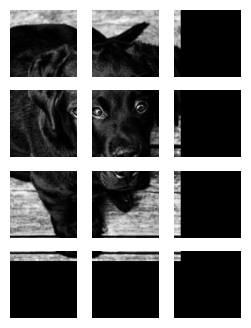

In [401]:
rows = prepare.n_patches_h
cols = prepare.n_patches_w

fig, axs = plt.subplots(rows, cols, figsize=(cols, rows))

for idx, img in enumerate(pimg):
    axs[idx // cols, idx % cols].imshow(img, cmap='gray')
    axs[idx // cols, idx % cols].axis('off')

plt.show()

Text(0.5, 1.0, 'Reconstructed Image')

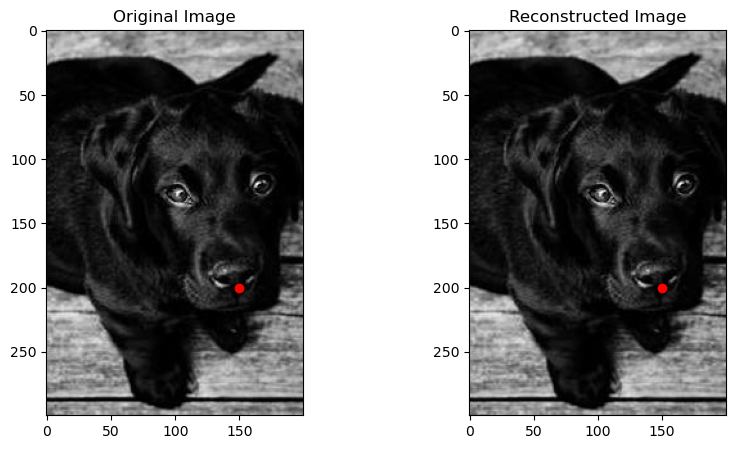

In [402]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with two subplots side by side

# Plot the original image on the first subplot
axs[0].imshow(gray_img, cmap='gray')
axs[0].scatter(150, 200, c='red') 
axs[0].set_title('Original Image')
# Plot the reconstructed image on the second subplot
axs[1].imshow(reconstructed, cmap='gray')
axs[1].scatter(150, 200, c='red') 

axs[1].set_title('Reconstructed Image')